# 데이터 정보 및 요구사항

Name : 게임의 이름입니다.

Platform : 게임이 지원되는 플랫폼의 이름입니다.

Year : 게임이 출시된 연도입니다.

Genre : 게임의 장르입니다.

Publisher : 게임을 제작한 회사입니다.

NA_Sales : 북미지역에서의 출고량입니다.

EU_Sales : 유럽지역에서의 출고량입니다.

JP_Sales : 일본지역에서의 출고량입니다.

Other_Sales : 기타지역에서의 출고량입니다.

>다음 분기에 어떤 게임을 설계해야 할까

* 데이터셋을 읽는 것 부터,이러한 게임을 만들어야 한다는 결론까지 의 과정을 colab을 사용하여 작성하고,해당 내용을 기반으로 설명하는 영상을 작성

>발표를 듣는 사람은 비데이터 직군이라 가정

반드시 들어가야 하는 내용

1. 지역에 따라서 선호하는 게임 장르가 다를까 라는 질문에 대답을 하셔야합니다.
2. 연도별 게임의 트렌드가 있을까 라는 질문에 대답을 하셔야합니다.
3. 출고량이 높은 게임에 대한 분석 및 시각화 프로세스가 포함되어야 합니다.

# 데이터 전처리

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import sklearn as sk
import matplotlib.pyplot as plt

# plotly 사용
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from plotly.validators.scatter.marker import SymbolValidator
from plotly.offline import plot

data = pd.read_csv("/content/vgames2.csv", index_col=0)
df = data.copy()
df.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
1,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0,0,0
2,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0,0,0.01
3,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0,0,0.02,0
4,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0,0,0
5,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0,0.04


## 결측치 및 이상치 제거로 데이터 정제

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16598 entries, 1 to 16598
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         16598 non-null  object 
 1   Platform     16598 non-null  object 
 2   Year         16327 non-null  float64
 3   Genre        16548 non-null  object 
 4   Publisher    16540 non-null  object 
 5   NA_Sales     16598 non-null  object 
 6   EU_Sales     16598 non-null  object 
 7   JP_Sales     16598 non-null  object 
 8   Other_Sales  16598 non-null  object 
dtypes: float64(1), object(8)
memory usage: 1.3+ MB


In [3]:
df_nan = df[df["Year"].isnull()|df["Genre"].isnull()|df["Publisher"].isnull()] #데이터 한번에 isnull 하는법 찾기
#결측치에 대해서 유추할 방법이 없으므로 drop
df.drop(df_nan.index, inplace=True)
#데이터 형태에 맞게 타입 정의
df.Year=df.Year.astype(int)

In [4]:
for i in df.iloc[:,5:]:
    df[i] = df[i].str.replace('M','')

for i in df.iloc[:,5:]:    
    df[i] = df[i].str.replace('K','000').astype(float) #연산을 위해 숫자데이터로 치환한다. 000
    N = df[df[i]>=10]
    N10 = N[i]/1000000 # 000을 곱해주었으므로 단위만큼 나누기
    df.loc[N10.index, i] = N10

In [5]:
#년도 이상치 제거 #2016년도 이후는 데이터가 거의 없으므로 drop
a = df[df.Year<=1900]
a1 = df[df.Year>2016]
df.drop(a.index, inplace=True)
df.drop(a1.index, inplace=True)
df['Global_Sales']=df[['NA_Sales','EU_Sales','JP_Sales', 'Other_Sales']].sum(axis=1)

In [6]:
df[df.duplicated()] #중복체크

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales


In [7]:
df.isnull().sum()

Name            0
Platform        0
Year            0
Genre           0
Publisher       0
NA_Sales        0
EU_Sales        0
JP_Sales        0
Other_Sales     0
Global_Sales    0
dtype: int64

1. 지역별 선호하는 게임의 장르가 다른가?
2. 연도별 게임의 트렌드가 있을까?

In [8]:
df.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
1,Candace Kane's Candy Factory,DS,2008,Action,Destineer,0.04,0.00,0.00,0.00,0.04
2,The Munchables,Wii,2009,Action,Namco Bandai Games,0.17,0.00,0.00,0.01,0.18
3,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010,Adventure,Alchemist,0.00,0.00,0.02,0.00,0.02
4,Deal or No Deal: Special Edition,DS,2010,Misc,Zoo Games,0.04,0.00,0.00,0.00,0.04
5,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010,Platform,D3Publisher,0.12,0.09,0.00,0.04,0.25


# 지역별 선호도 시각화 (플랫폼, 장르)

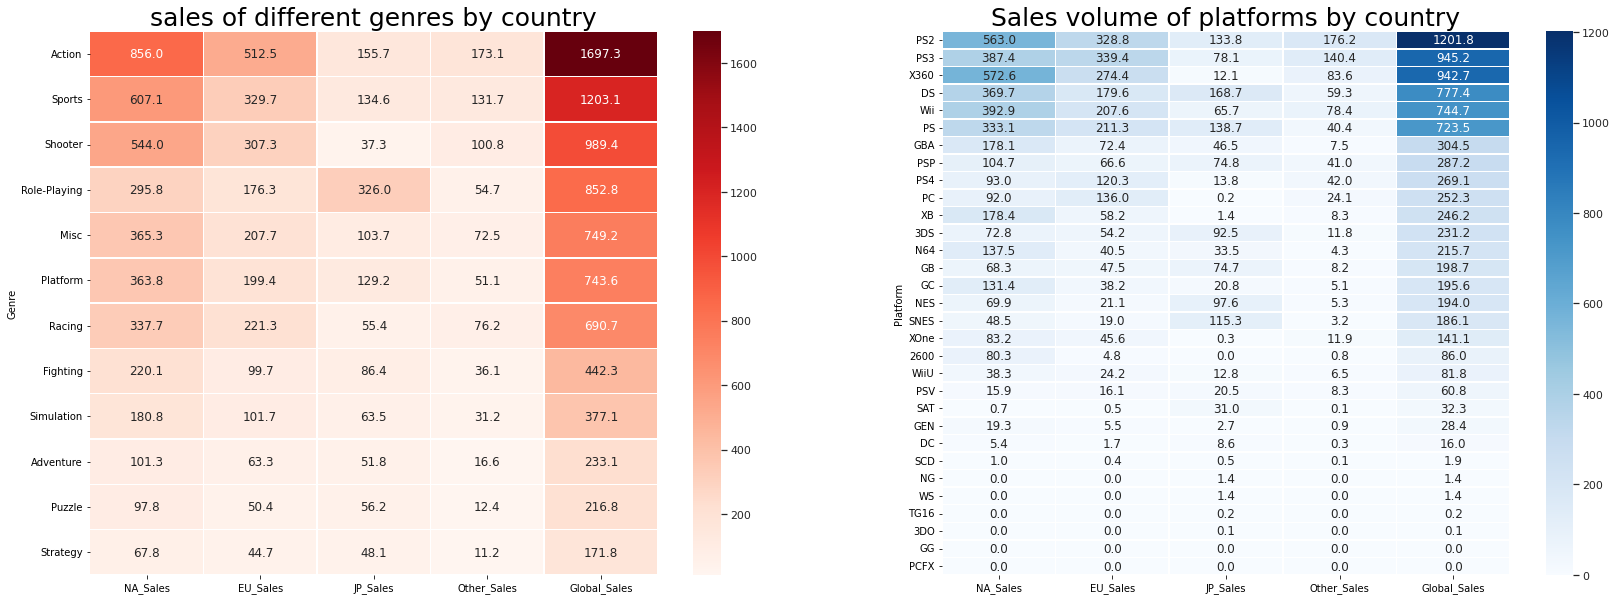

In [9]:
#나라별 판매량 합으로 보는 장르 선호도
df_genre_local = df[['NA_Sales','EU_Sales','JP_Sales', 'Other_Sales','Genre','Global_Sales']].groupby('Genre').sum()
df_pla_local = df[['NA_Sales','EU_Sales','JP_Sales', 'Other_Sales','Platform','Global_Sales']].groupby('Platform').sum()

fig, axes = plt.subplots(1, 2, figsize=(28, 10))
sns.set(font_scale=1)
sns.heatmap(df_genre_local.sort_values(by=['Global_Sales'],ascending=False), annot=True, fmt = '.1f',linewidth=0.5, cmap="Reds", ax=axes[0])
sns.heatmap(df_pla_local.sort_values(by=['Global_Sales'],ascending=False), annot=True, fmt = '.1f',linewidth=0.5, cmap="Blues", ax=axes[1])
axes[0].set_title("sales of different genres by country",fontsize=25)
axes[1].set_title("Sales volume of platforms by country",fontsize=25)
plt.show()

* 대체적으로 같은 모양을 띄고 있으나 Racing, Role-Playing 등 몇몇 장르에서는 지역별 선호하는 게임의 장르가 다름

# 연도,장르,플랫폼 별 발매량

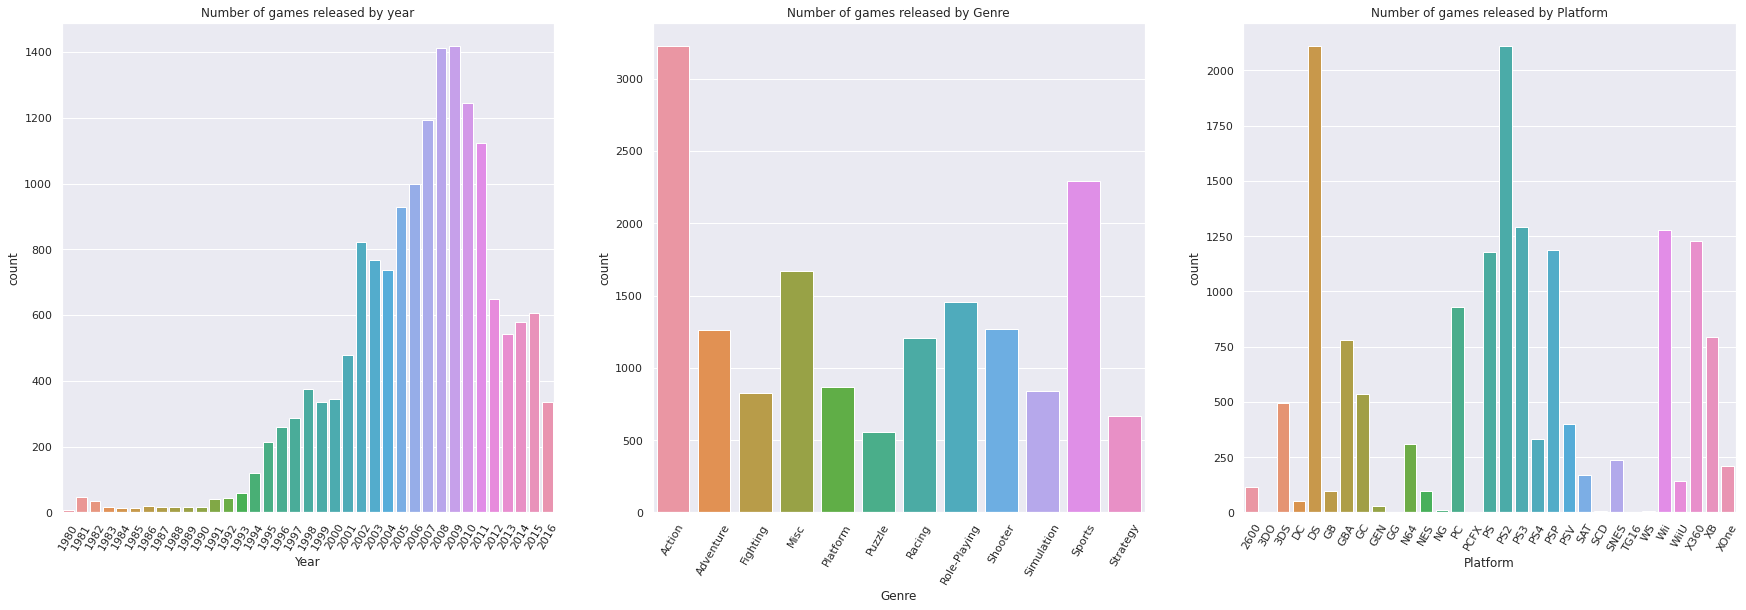

In [10]:
#연도별 게임 출시수와 장르별 게임 수
fig, axes = plt.subplots(1, 3, figsize=(30, 10))
sns.countplot(x="Year", data=df, order = df.groupby(by=['Year'])['Name'].count().index, ax=axes[0])
sns.countplot(x="Genre", data=df, order = df.groupby(by=['Genre'])['Name'].count().index, ax=axes[1])
sns.countplot(x='Platform', data=df, order = df.groupby(by=['Platform'])['Name'].count().index, ax=axes[2])
axes[0].set_title("Number of games released by year")
axes[1].set_title("Number of games released by Genre")
axes[2].set_title("Number of games released by Platform")
fig.autofmt_xdate(rotation= 60,ha='center')

# 연도,장르,플랫폼 별 출고량

In [11]:
total_genre =df.groupby('Genre')['Global_Sales'].sum().round(2)
total_year =df.groupby('Year')['Global_Sales'].sum().round(2)
total_platform =df.groupby('Platform')['Global_Sales'].sum().round(2)
total_genre = total_genre.reset_index()
total_year= total_year.reset_index()
total_platform = total_platform.reset_index()

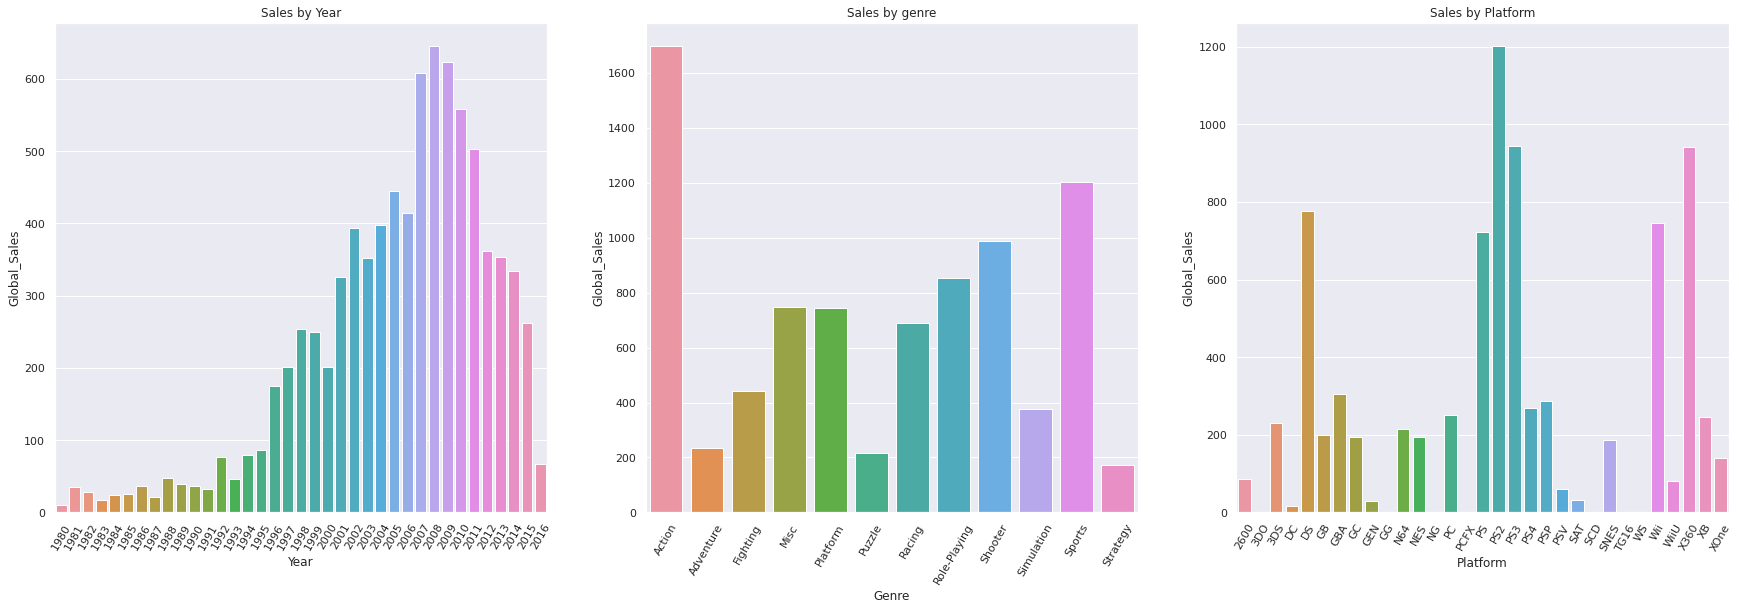

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(30, 10))
sns.barplot(data=total_year,x='Year',y='Global_Sales',ax=axes[0])
sns.barplot(data=total_genre,x='Genre',y='Global_Sales',ax=axes[1])
sns.barplot(data=total_platform ,x='Platform',y='Global_Sales',ax=axes[2])
axes[0].set_title("Sales by Year")
axes[1].set_title("Sales by genre")
axes[2].set_title("Sales by Platform")
fig.autofmt_xdate(rotation= 60,ha='center')

* 발매 수와 출고량의 분포로 보았을 때 대체적으로 유사하나 발매수에 비례해 선호도가 높다고는 할 수 없다.

# 연도별 게임의 트렌드

## 장르별 출고량의 년도 분포

In [13]:
df2 = df.loc[:,['Year','Genre','Global_Sales']]
df2['Total_Sales'] = df2.groupby(['Genre','Year'])['Global_Sales'].transform('sum') # groupby 집계결과 추가하기 = transform
df2.drop('Global_Sales', axis=1, inplace=True)
df2 = df2.drop_duplicates()
df2 = df2.sort_values('Year')

In [14]:
fig=px.bar(df2,x ='Genre', y ='Total_Sales', animation_frame='Year',animation_group='Genre', hover_name ='Genre',range_x=[0,12],range_y=[0,150])
#color를 넣으면 오류뜸 = 첫번째 기준으로 color를 설정하기 때문
fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 2500 # 속도조절
fig.show()

In [15]:
# df_genre_sale = df[['Year','Genre','Global_Sales']].groupby(['Genre','Year']).sum()
# df_genre_sale = df_genre_sale.reset_index()
# sale_genre = sns.catplot(kind='bar',data=df_genre_sale, x='Year',y='Global_Sales',col='Genre', col_wrap=4)
# sale_genre.set(xticklabels=[])# xtick 지우기
# plt.suptitle("Year distribution of sales by genre.",y=1.05,fontsize=25);

## 플랫폼별 출고량의 연도 분포

In [16]:
df3 = df.loc[:,['Year','Platform','Global_Sales']]
df3['Total_Sales'] = df3.groupby(['Platform','Year'])['Global_Sales'].transform('sum') # 집계결과 추가하기
df3.drop('Global_Sales', axis=1, inplace=True)
df3 = df3.drop_duplicates()
df3 = df3.sort_values('Year')

In [17]:
fig=px.bar(df3,x ='Platform', y ='Total_Sales', animation_frame='Year',animation_group='Platform', hover_name ='Platform',range_x=[0,15],range_y=[0,220])
fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 2500
fig.show()

In [18]:
# df_pla_sale = df[['Year','Platform','Global_Sales']].groupby(['Platform','Year']).sum()
# df_pla_sale = df_pla_sale.reset_index()
# pla_sale = sns.catplot(kind='bar',data=df_pla_sale, x='Year',y='Global_Sales',col='Platform', col_wrap=5)
# pla_sale.set(xticklabels=[])# xtick 지우기
# plt.suptitle("Year distribution of sales by Platfrom",y=1.05,fontsize=25);

* 시간이 지남에 따라 플랫폼과 장르의 선호도가 달라지는것을 볼 수 있다.

# 인기있는 게임의 장르, 플랫폼, 퍼블리셔

In [19]:
#top 50의 장르와 연도, 플랫폼 확인하기
df_Total = df.Global_Sales.sort_values(ascending=False).head(100).index
df_Top100 = df.loc[df_Total].reset_index(drop=True)
# 각각의 갯수를 구해줘도됨
gen_100 = df_Top100['Genre'].value_counts()
pla_100 = df_Top100['Platform'].value_counts()
pub_100 = df_Top100['Publisher'].value_counts()

In [20]:
fig = px.sunburst(df_Top100, path=['Publisher','Genre','Platform'], values='Global_Sales',width=800)
fig.update_layout(
    title=dict(
        text='Distribution of the top 100 games',
        x=0.5,
        y=0.98,
        font=dict(
            family="Arial",
            size=35,
            color="#000000"           
        )))
fig.show()

In [21]:
fig = px.pie(gen_100, values=gen_100.values, names=gen_100.index, hole=.5, color_discrete_sequence=px.colors.sequential.RdBu,width=800)
fig.update_traces(pull=[0.06,0.06,0.06,0.06,0.06],textposition='inside', textinfo='percent+label')
fig.update_layout(
    title=dict(
        text='Top 100 Genre',
        x=0.465,
        y=0.52,
        font=dict(
            family="Arial",
            size=23,
            color="#000000"           
        )))
fig.show()

In [22]:
fig = px.pie(pla_100, values=pla_100.values, names=pla_100.index, hole=.5,color_discrete_sequence=px.colors.sequential.PuBu_r, width=800)
fig.update_traces(pull=[0.06,0.06,0.06,0.06,0.06],textposition='inside', textinfo='percent+label')
fig.update_layout(
    title=dict(
        text='Top 100 Platform',
        x=0.485,
        y=0.52,
        font=dict(
            family="Arial",
            size=23,
            color="#000000"           
        )))
fig.show()

* 이를 기반으로 출시를 한다면 장르는 Action, Role-Playing, Shooter 플랫폼은 X360, PS3를 염두해두고 PS4, WiiU, XOne, 3DS를 고려하는 것이 좋아보인다. ex)GTA5

## 상위 100 게임 중 가장 트렌드를 잘 반영하는 게임사
* 출고량이 높은 상위 100게임을 출시한 게임사는 트렌드디 한가?

In [23]:
fig = px.pie(pub_100, values=pub_100.values, names=pub_100.index, hole=.5, color_discrete_sequence=px.colors.sequential.Peach,width=800)
fig.update_traces(pull=[0.06,0.06,0.06,0.06,0.06],textposition='inside', textinfo='percent+label')
fig.update_layout(
    title=dict(
        text='Top 100 Publisher',
        x=0.40,
        y=0.52,
        font=dict(
            family="Arial",
            size=23,
            color="#000000"           
        )))
fig.show()

In [24]:
k = df_Top100[(df_Top100.Genre=='Action')|(df_Top100.Genre=='Role-Playing')|(df_Top100.Genre=='Shooter')]
k = k[(k.Platform=='X360')|(k.Platform=='PS3')|(k.Platform=='PS4')|(k.Platform=='WiiU')|(k.Platform=='XOne')|(k.Platform=='3DS')]
k = k.Publisher.value_counts()
fig = px.pie(k, values=k.values, names=k.index, hole=.5, color_discrete_sequence=px.colors.sequential.PuRd_r,width=800)
fig.update_traces(pull=[0.06,0.06,0.06,0.06,0.06],textposition='inside', textinfo='percent+label')
fig.update_layout(
    title=dict(
        text='Trendy Game Publisher',
        x=0.435,
        y=0.98,
        font=dict(
            family="Arial",
            size=35,
            color="#000000"           
        )))
fig.show()

* 출고량이 높은 게임에 가장 많은 판매를 한 게임사는 닌텐도이지만 트렌드를 보았을 때 액티비전이 많은 비중을 차지한다. 닌텐도는 3.5%로 낮은 비율을 보인다.

In [25]:
import plotly.io as pio
pio.write_html(fig,file='index.html',auto_open=True)